In [100]:
import pickle
import fnmatch
import os
import torch
from sklearn.model_selection import train_test_split
from pathlib import Path
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from params import RANDOM_SEED, LocationConfig, CreateDataConfig
from PIL import Image
import insightface

In [55]:
total_f=0
for image_path in tqdm(Path(LocationConfig.images).glob('*.png')):
    total_f += 1

440it [00:00, 211324.15it/s]


In [3]:
class FaceDetection:
    def __init__(self, use_gpu=True):
        self.use_gpu = use_gpu
        self.image_size = 640
        self.det_thresh = 0.7
        self.detector = self._get_face_detection_model()

    def _get_device_used_code(self):
        if not self.use_gpu:
            return -1
        return 1

    def _get_face_detection_model(self):
        app_kwargs = {'providers': ['CPUExecutionProvider','CUDAExecutionProvider']}
        model_detector_path = '../model/det_10g.onnx'
        detector = insightface.model_zoo.get_model(model_detector_path, **app_kwargs)
        detector.prepare(ctx_id=self._get_device_used_code(), det_thresh=self.det_thresh, input_size=(self.image_size, self.image_size))
        return detector

    def detect_face(self, img: np.ndarray) -> np.ndarray:
        """
        Detects a face in an image

        Parameters
        ----------
        img
            Input image with a face
        Returns
        -------
        Bounding box of the original face
        """
        bboxes, _ = self.detector.detect(img)
        return bboxes

In [4]:
def create_new_data_directories():
    Path(LocationConfig.data).mkdir(exist_ok=True, parents=True)
    Path(LocationConfig.data + 'train').mkdir(exist_ok=True, parents=True)
    Path(LocationConfig.data + 'test').mkdir(exist_ok=True, parents=True)
    Path(LocationConfig.crop_images).mkdir(exist_ok=True, parents=True)
    
create_new_data_directories()

In [126]:
import torchvision.transforms.functional as F
from torchvision import transforms, datasets

class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = 311 #np.max([w, h])
		hp = int((243 - w) / 2)
		vp = int((311 - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 0, 'constant')

# now use it as the replacement of transforms.Pad class
transform=transforms.Compose([
    SquarePad(),
    transforms.Resize((311, 243)),
    transforms.CenterCrop((311, 243)),
    transforms.ToTensor(),
    transforms.Normalize((0.4786, 0.5226, 0.6365), (0.3238, 0.3334, 0.3707)),
])

In [129]:
# list_of_face_shapes = [[],[],[]]
def detect_and_crop(face_detect_app: FaceDetection, input_path: Path, output_path: str, img_num: int):
    img = cv2.imread(str(input_path))
    faces = face_detect_app.detect_face(img)
    if len(faces) == 0 or len(faces) > 1:
        return

    face_box = faces[0].astype(np.int32)
    width = (face_box[3] - face_box[1]) // 7
    height = (face_box[2] - face_box[0]) // 7
    try:
        new_img = img[max(face_box[1]-width, 0) : min(face_box[3]+width, img.shape[0]-1), max(face_box[0]-height, 0) : min(face_box[2]+height, img.shape[1]-1)]
    except IndexError:
        print('ROZMIAR NIE DZIALA')
        return
    if new_img is None:
        return
    new_img = transform(Image.fromarray(new_img))
    new_img = new_img.permute(1, 2, 0)
    filename = str(input_path).split('/')[-1]
    cv2.imwrite(os.path.join(output_path,filename), np.array(new_img))
    return new_img

In [130]:
face_detector = FaceDetection()
i=0
images = []
for image_path in tqdm(Path(LocationConfig.images).glob('*.png'), total=total_f):
    images.append(detect_and_crop(face_detector, image_path, LocationConfig.crop_images, i))
    i+=1

/home/karol/miniconda3/envs/ur/lib/python3.8/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:55: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn("Specified provider '{}' is not in available provider names."


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


100%|██████████| 440/440 [05:13<00:00,  1.41it/s]


In [132]:
images_t = torch.stack(images)

In [125]:
torch.mean(images_t, dim = [0, 1, 2]), torch.std(images_t, dim = [0, 1, 2])

(tensor([0.4786, 0.5226, 0.6365]), tensor([0.3238, 0.3334, 0.3707]))

In [136]:
torch.mean(images_t, dim = [0, 1, 2]), torch.std(images_t, dim = [0, 1, 2])

(tensor([ 1.3533e-04,  8.2278e-05, -9.4415e-05]),
 tensor([1.0000, 0.9999, 0.9999]))

In [135]:
images_t.shape

torch.Size([440, 311, 243, 3])

In [137]:
def create_dataset(images_path):
    df = pd.read_csv(LocationConfig.labels + 'bigfive_labels.csv', index_col=0)
    df
    X_train, X_test = train_test_split(
        np.array(df.index), 
        test_size=CreateDataConfig.test_size_ratio,
        random_state=0
    )

    images_dict_train = {'X':[], 'Y':[]}
    images_dict_test = {'X':[], 'Y':[]}
    total_files = len(fnmatch.filter(os.listdir(images_path), '*.png'))

    for image_path in tqdm(Path(images_path).glob('*.png'), total=total_files):
        X = cv2.imread(str(image_path)) 
        Y = df.loc[image_path.name].values
        if CreateDataConfig.classification:
            Y = list(np.where(Y>CreateDataConfig.Y_threshold, 1, 0))
            
        if image_path.name in X_test:
            images_dict_test['X'].append(X)
            images_dict_test['Y'].append(Y)
        else:
            images_dict_train['X'].append(X)
            images_dict_train['Y'].append(Y)
            
    with open(LocationConfig.data + 'train/train.pickle', 'wb') as handle:
        pickle.dump(images_dict_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(LocationConfig.data + 'test/test.pickle', 'wb') as handle:
        pickle.dump(images_dict_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
create_dataset(LocationConfig.crop_images)

100%|██████████| 440/440 [00:00<00:00, 564.34it/s]


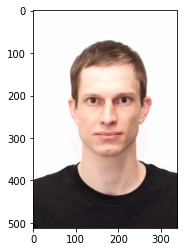

In [139]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook


img = cv2.imread('../data/BFD/images/27_Conscientiousness_enhanced.png')
#Show the image with matplotlib
plt.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
plt.show()